#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
        'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
        'local_train': '1e4GeqU0uIlbJ9_ENJ6mM13kUGwuasuvz',
        'local_test' : '1jU1N5Ki9ikwdJMAaqy7xhVMz2ZNKzWj_',
        'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
        'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
        'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
        'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
        'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import gdown

import time

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision.transforms import v2

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

<ipython-input-4-d75d84943b53>:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [6]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [39]:
def kfold_split(num_objects: int,
                num_folds: int) -> list[tuple[np.ndarray, np.ndarray]]:
    step = num_objects // num_folds
    ans = []
    for i in range(0, num_folds - 1):
        ans.append((np.concatenate((np.arange(0, i * step, dtype=np.int32),
                                    np.arange((i + 1) * step, num_objects, dtype=np.int32))), np.arange(i * step, (i + 1) * step, dtype=np.int32)))
    ans.append((np.arange(0, (num_folds - 1) * step, dtype=np.int32), np.arange((num_folds - 1) * step, num_objects, dtype=np.int32)))
    return ans

class Dataloader:
    ''' Класс для загрузки батчей из датасета:
    1) С применением необходимых для torch преобразований
    2) С применинием преобразований гененрирующих дополнительные данные
    3) Есть возможность использовать часть тестовой выборки (если нужна частая валидация)
    '''
    def __init__(self, dataset : Dataset, indices : np.array, batch_size, transforms=None, augmenting_transforms=None, limit=1.):
        self.dataset = dataset
        self.indices = indices
        self.batch_size = batch_size
        self.num_batch = len(indices) // batch_size
        self.n_batch = -1
        self.transforms = transforms
        self.augmenting_transforms = augmenting_transforms
        self.limit = limit

    def __iter__(self):
        self.n_batch = 0
        return self

    def __next__(self):

        np.random.shuffle(self.indices)

        if self.n_batch < self.num_batch * self.limit:

            first = self.n_batch * self.batch_size
            images = torch.empty((self.batch_size, 3, 224, 224))
            labels = torch.empty(self.batch_size, dtype=torch.int32)

            for i in range(self.batch_size):
                image, label = self.dataset.image_with_label(self.indices[first + i])
                image = torch.from_numpy(image).permute(2, 0, 1)
                #LBL6
                if self.augmenting_transforms:
                    image = self.augmenting_transforms(image)
                if self.transforms:
                    image = self.transforms(image)
                images[i] = image
                labels[i] = torch.tensor(label)

            self.n_batch += 1
            return [images.type(torch.FloatTensor), labels.type(torch.LongTensor)]
        else:
            raise StopIteration

class CrossVal:
    #LBL2
    def __init__(self, dataset : Dataset, batch_size, num_folds, transforms=None, augmenting_transforms=None, seed=42, limit=(1., 1.)):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_folds = num_folds
        self.folds = kfold_split(dataset.n_files, num_folds)
        self.indices = np.arange(0, dataset.n_files)
        self.transforms = transforms
        self.augmenting_transforms = augmenting_transforms
        np.random.seed(seed)
        np.random.shuffle(self.indices)
        self.n_val = 0
        self.limit = limit

    def get_train_val(self):
        train_indices = self.indices[self.folds[self.n_val][0]]
        val_indices = self.indices[self.folds[self.n_val][1]]
        self.n_val = (self.n_val + 1) % self.num_folds
        return (Dataloader(self.dataset, train_indices, self.batch_size, self.transforms, self.augmenting_transforms, limit=self.limit[0]),
                Dataloader(self.dataset, val_indices, self.batch_size, self.transforms, self.augmenting_transforms, limit=self.limit[1]))

def create_model(model, num_freeze_layers, num_out_classes):
    model.fc = nn.Linear(512, num_out_classes)

    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

class Model:

    def __init__(self):
        self.model = create_model(torchvision.models.resnet18(pretrained=True), 6, 9).to(device)
        #self.transforms = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()
        self.transforms = v2.Compose([
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

    def save(self, name: str):
        torch.save(self.model.state_dict(), f'/content/drive/MyDrive/Digital Pathology/{name}.txt')
        #np.savez(f'/content/drive/MyDrive/{name}.npz', data=arr)

    def load(self, name: str):
        name_to_id_dict = {
            'best': '1RYOja4fM77nmqxLUrXJb-FOqd6R9I4A3'
        }
        output = f'{name}.npz'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
        self.model.load_state_dict(torch.load(output))
        self.model.to(device)
        self.model.eval()

    def evaluate(self, dataloader : Dataloader, loss_fn, weights):

        losses = []

        num_correct = np.zeros(9, dtype=int)
        num_elements = np.zeros(9, dtype=int)

        for i, batch in enumerate(dataloader):

            # так получаем текущий батч
            X_batch, y_batch = batch

            with torch.no_grad():
                logits = self.model(X_batch.to(device))

                loss = loss_fn(logits, y_batch.to(device))
                losses.append(loss.item())

                y_pred = torch.argmax(logits, dim=1).cpu()
                num_elements += (y_batch.numpy()[None, :].T.repeat(9, axis=1) == np.arange(9)).astype(int).sum(axis=0)

                num_correct += ((y_batch.numpy()[None, :].T.repeat(9, axis=1) == np.arange(9)).astype(int) * (y_batch.numpy()[None, :].T == y_pred.numpy()[None, :].T).astype(int).repeat(9, axis=1)).sum(axis=0)

        acc = num_correct / num_elements
        #LBL7
        weights = torch.from_numpy(acc ** 6)

        accuracy = num_correct.sum() / num_elements.sum()

        return accuracy, np.mean(losses), weights

    def train(self, dataset: Dataset):

        optim = torch.optim.Adamax
        lossF = torch.nn.CrossEntropyLoss

        learning_rate = 1e-4

        optimizer = optim(self.model.parameters(), lr=learning_rate)
        #LBL8
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=0.01, threshold_mode='rel')


        #LBL6
        augmenting_transforms = v2.Compose([
            v2.RandomHorizontalFlip(),
            v2.RandomVerticalFlip(),
            #v2.ColorJitter(brightness=0.12, contrast=0.3)
            ])

        batch_size = 32
        folds = 10
        limit = (0.3, 1.)
        dataloader = CrossVal(dataset, batch_size, folds, self.transforms, augmenting_transforms=augmenting_transforms, limit=limit)
        print(f'training started')

        history = ''

        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []

        local_train_loss_history = []
        local_train_acc_history = []

        n_epoch = 40
        eval_every = 40

        weights = torch.ones(9)

        for epoch in range(n_epoch):

            print("Epoch:", epoch+1)
            history += f"Epoch: {epoch+1}\n"
            #LBL7
            loss_fn = lossF(weight=weights.type(torch.FloatTensor).to(device))

            train, val = dataloader.get_train_val()

            self.model.train(True)

            for i, batch in enumerate(train):

                start_time = time.time()
                X_batch, y_batch = batch

                logits = self.model(X_batch.to(device))

                loss = loss_fn(logits, y_batch.to(device))

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                model_answers = torch.argmax(logits, dim=1)
                train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)

                local_train_loss_history.append(loss.item())
                local_train_acc_history.append(train_accuracy)

                if (i + 1) % eval_every == 0:
                    #LBL3
                    history += f"Средние train лосс и accuracy на последних {eval_every} итерациях: {np.mean(local_train_loss_history)} {np.mean(local_train_acc_history)} \n"
                    print(f"Средние train лосс и accuracy на последних {eval_every} итерациях:",
                      np.mean(local_train_loss_history), np.mean(local_train_acc_history), end='\n')

            self.model.train(False)

            #LBL1
            val_accuracy, val_loss, weights = self.evaluate(val, loss_fn, weights)
            #LBL8
            scheduler.step(val_loss)

            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            val_loss_history.append(val_loss)
            val_acc_history.append(val_accuracy)

            IPython.display.clear_output(wait=True)
            #LBL4
            plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

            history += f"Эпоха {epoch+1}/{n_epoch}: val лосс и accuracy: {val_loss} {val_accuracy} \n"
            history += f"New weights {weights} \n"
            history += f"Learning rate {optimizer.state_dict()['param_groups'][0]['lr']} \n"
            #self.save(f'Epoch {epoch+1} Val accuracy {val_accuracy}')
            #LBL3
            print(history)

        print(f'training done')

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        prediction = self.model(self.transforms(torch.from_numpy(img).permute(2, 0, 1))[None, :, :, :].to(device))
        prediction = int(torch.argmax(prediction, dim=1).cpu()[0])
        return prediction


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [10]:
#d_train = Dataset('train_small')
d_train = Dataset('local_train')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1e4GeqU0uIlbJ9_ENJ6mM13kUGwuasuvz
To: /content/local_train.npz
100%|██████████| 2.10G/2.10G [00:23<00:00, 91.1MB/s]


Loading dataset local_train from npz.
Done. Dataset local_train consists of 18000 images.


In [44]:
model = Model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
model.load('best')

Downloading...
From: https://drive.google.com/uc?id=1RYOja4fM77nmqxLUrXJb-FOqd6R9I4A3
To: /content/best.npz
100%|██████████| 44.8M/44.8M [00:00<00:00, 186MB/s]


In [50]:
for i, layer in enumerate(model.model.children()):
    if i < 3:
        for param in layer.parameters():
            param.requires_grad = False
    else:
        for param in layer.parameters():
            param.requires_grad = True

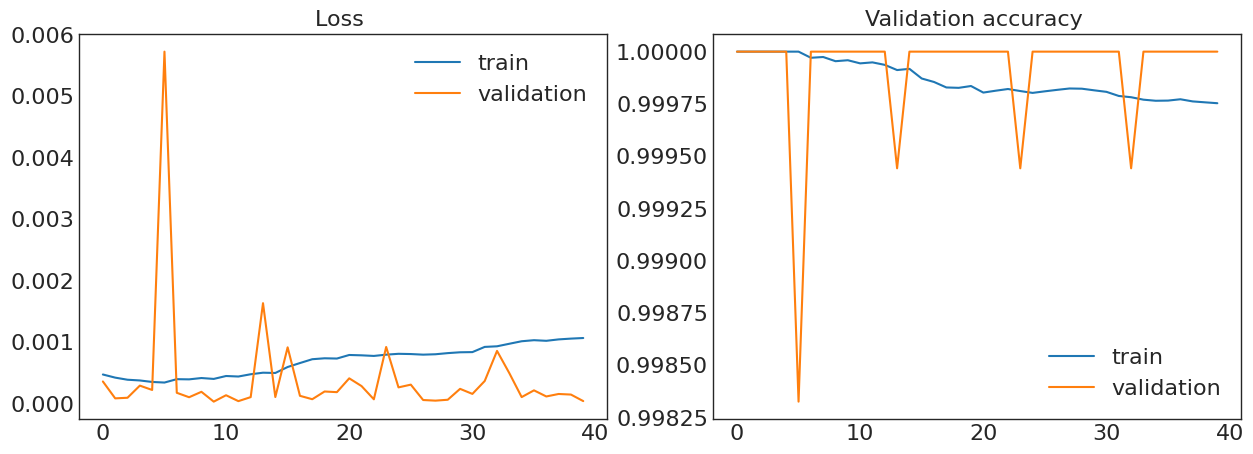

Epoch: 1
Средние train лосс и accuracy на последних 40 итерациях: 0.0003929504780629145 1.0 
Средние train лосс и accuracy на последних 40 итерациях: 0.0004660609637859636 1.0 
Средние train лосс и accuracy на последних 40 итерациях: 0.00048215150088471624 1.0 
Эпоха 1/40: val лосс и accuracy: 0.00035682546824286225 1.0 
New weights tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64) 
Learning rate 0.0001 
Epoch: 2
Средние train лосс и accuracy на последних 40 итерациях: 0.0005217661510158086 1.0 
Средние train лосс и accuracy на последних 40 итерациях: 0.00047875581951497626 1.0 
Средние train лосс и accuracy на последних 40 итерациях: 0.0004435255765686296 1.0 
Эпоха 2/40: val лосс и accuracy: 8.233068752667399e-05 1.0 
New weights tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64) 
Learning rate 0.0001 
Epoch: 3
Средние train лосс и accuracy на последних 40 итерациях: 0.00043955145811959835 1.0 
Средние train лосс и accuracy на последних 40 итерациях: 0.

In [51]:
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

In [59]:
#LBL5
def conf_matrix(gt: List[int], pred: List[int]):
    plt.figure(figsize=(8,6), dpi= 80)
    matrix = confusion_matrix(gt, pred)
    sns.heatmap(matrix, xticklabels=np.arange(9), yticklabels=np.arange(9), cmap='RdYlGn', center=0, annot=True)

    # Decorations
    plt.title('Confusion Matrix', fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

Пример тестирования модели на части набора данных:

In [ ]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
conf_matrix(d_test.labels[:len(pred_1)], pred_1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

In [35]:
d_real_test = Dataset('local_test')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1jU1N5Ki9ikwdJMAaqy7xhVMz2ZNKzWj_
To: /content/local_test.npz
100%|██████████| 525M/525M [00:05<00:00, 100MB/s] 


Loading dataset local_test from npz.
Done. Dataset local_test consists of 4500 images.


Пример тестирования модели на полном наборе данных:

  0%|          | 0/4500 [00:00<?, ?it/s]

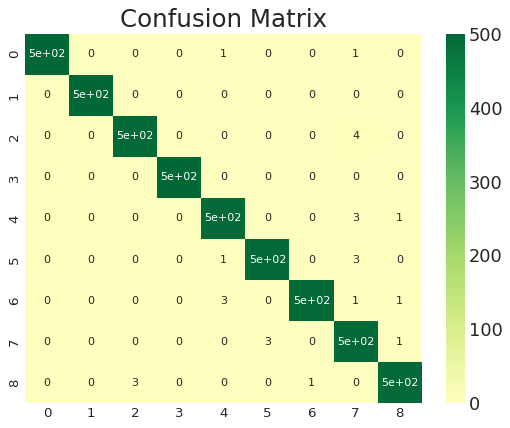

metrics for test:
	 accuracy 0.9940:
	 balanced accuracy 0.9940:


In [60]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_real_test)
    conf_matrix(d_real_test.labels, pred_2)
    Metrics.print_all(d_real_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [56]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading...
From: h

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9889:
	 balanced accuracy 0.9889:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"